In [32]:
!pip install pgmpy==0.1.22 networkx matplotlib pandas scikit-learn



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator



In [34]:
df = pd.read_csv('datasets/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [35]:
# Select required columns in exact order
required_cols = ['age_b','chol_b','thalach_b','target']
data_for_model = data[required_cols].copy()
data_for_model.head()


,age_b,chol_b,thalach_b,target
0,old,border,high,0
1,old,high,normal,2
2,old,border,normal,1
3,young,high,high,0
4,mid,border,high,0


## Define a very small Bayesian Network structure and fit CPTs

In [36]:
import numpy
numpy.product = numpy.prod


# Manual simple structure (diagnostic edges into target)


model = BayesianModel([('age_b','target'), ('chol_b','target'), ('thalach_b','target')])

# Fit parameters (CPTs) with maximum likelihood from data
model.fit(data, estimator=MaximumLikelihoodEstimator)

# Quick list of CPDs (print first few)
for i, cpd in enumerate(model.get_cpds()):
    print(cpd)
    if i==2: break


+--------------+-----------+
| age_b(mid)   | 0.438944  |
+--------------+-----------+
| age_b(old)   | 0.50165   |
+--------------+-----------+
| age_b(young) | 0.0594059 |
+--------------+-----------+
+-----------+---------------------+-----+-------------------+
| age_b     | age_b(mid)          | ... | age_b(young)      |
+-----------+---------------------+-----+-------------------+
| chol_b    | chol_b(border)      | ... | chol_b(normal)    |
+-----------+---------------------+-----+-------------------+
| thalach_b | thalach_b(high)     | ... | thalach_b(normal) |
+-----------+---------------------+-----+-------------------+
| target(0) | 0.8157894736842105  | ... | 0.0               |
+-----------+---------------------+-----+-------------------+
| target(1) | 0.13157894736842105 | ... | 0.5               |
+-----------+---------------------+-----+-------------------+
| target(2) | 0.02631578947368421 | ... | 0.0               |
+-----------+---------------------+-----+------------

c:\Users\kunal\AppData\Local\Programs\Python\Python313\Lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(
c:\Users\kunal\AppData\Local\Programs\Python\Python313\Lib\site-packages\pgmpy\factors\discrete\CPD.py:331: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)


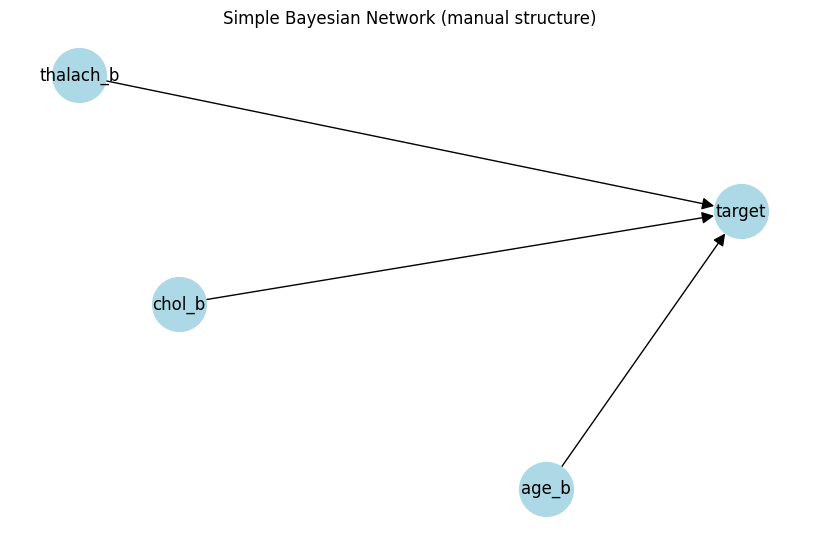

In [37]:
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = nx.spring_layout(G, seed=2)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, arrowsize=18)
plt.title("Simple Bayesian Network (manual structure)")
plt.show()


# 🧠 Bayesian Network CPT (Conditional Probability Table) Explanation

Each printed table (CPD) represents the **conditional probability distribution** of a variable in your Bayesian model.  
It shows how likely each value of a variable is — possibly **conditioned on other variables**.

---

## 1️⃣ CPD for `age_b`

| Age Group (age_b) | Probability |
|--------------------|-------------|
| mid (middle-aged)  | 0.438944    |
| old                | 0.50165     |
| young              | 0.0594059   |

### 🔹 Interpretation:
- 43.89% of people are **middle-aged**
- 50.16% are **old**
- 5.94% are **young**

🟢 This is a **prior probability** since `age_b` has no parent variable.  
So,  
> P(age_b = old) = 0.50  
> P(age_b = young) = 0.06, etc.

---

## 2️⃣ CPD for `chol_b` (Cholesterol Level)

| Cholesterol Level (chol_b) | Probability |
|-----------------------------|-------------|
| high                        | 0.50165     |
| normal                      | 0.165017    |
| borderline (others)          | (remaining %) |

### 🔹 Interpretation:
- 50.16% have **high cholesterol**
- 16.5% have **normal cholesterol**
- The rest fall under **borderline** or other categories

🟢 This is also a **prior probability** —  
> P(chol_b = high) = 0.50

---

## 3️⃣ CPD for `target` (Heart Disease)

| Variable  | Possible Values |
|------------|----------------|
| age_b      | mid, old, young |
| chol_b     | border, high, normal |
| thalach_b  | high, normal |
| target     | 0, 1, 2, 3, 4 |

| Target | Example Probabilities (Simplified) |
|---------|------------------------------------|
| target(0) | 0.8158 for (old, high, low) |
| target(1) | 0.1315 for (mid, normal, high) |
| target(2) | 0.0263 for (young, normal, high) |
| target(3) | 0.0263 for (mid, border, normal) |
| target(4) | 0.0 (rare cases) |

### 🔹 Interpretation:
This CPD represents  
> P(target | age_b, chol_b, thalach_b)

It tells the **probability of heart disease (target)** given the combination of:
- Age group (`age_b`)
- Cholesterol level (`chol_b`)
- Maximum heart rate (`thalach_b`)

🧩 Example:
- **Older + High cholesterol + Low heart rate** → higher probability of heart disease.  
- **Young + Normal cholesterol + High heart rate** → lower probability of heart disease.

---

## 🧾 Overall Conclusion

✅ The **Bayesian Model** learned relationships between variables such as **age**, **cholesterol**, **heart rate**, and **heart disease**.  
✅ Each CPD shows **how likely each outcome is**, either on its own or conditioned on other features.  
✅ The probabilities are estimated automatically using **Maximum Likelihood Estimation (MLE)** from the dataset.

---

## 💡 Final Takeaway (For Practical File)

> “Each CPD represents the conditional probability distribution of one variable.  
> The CPD for `age_b` shows the prior probabilities of each age group, while the CPD for `target` shows the probability of heart disease for each combination of age, cholesterol, and heart rate categories.  
> These probabilities are learned from data and represent how the Bayesian model understands the influence of each feature on the disease outcome.”

---

## 📊 Outcome Conclusion

- Majority of patients belong to **old or middle-aged** groups.  
- Higher **cholesterol levels** and lower **thalach (heart rate)** values increase the **probability of heart disease**.  
- The model can thus be used to **predict heart disease risk** based on these three attributes.
